# Capstone Project:Initial Report and Exploratory Data Analysis (EDA)

### Import required libraries

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Set Seaborn style

In [19]:

sns.set(style="whitegrid")

### Load the dataset

In [21]:
file_path = "C:\\Users\\粟登洋\\Documents\\WeChat Files\\wxid_1dovcnv8u90022\\FileStorage\\File\\2024-09\\ai_job_market_insights.csv"
df = pd.read_csv(file_path)

### Ensure Salary_USD column is numeric

In [22]:
salary_col = 'Salary_USD'
if salary_col not in df.columns:
    raise ValueError(f"{salary_col} column not found in dataset!")
df[salary_col] = df[salary_col].replace('[\$,]', '', regex=True).astype(float)

### Convert categorical columns to appropriate data types

In [23]:
df['AI_Adoption_Level'] = df['AI_Adoption_Level'].astype('category')
df['Automation_Risk'] = df['Automation_Risk'].astype('category')
df['Remote_Friendly'] = df['Remote_Friendly'].map({'Yes': True, 'No': False})

### Display dataset info

In [24]:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Job_Title              500 non-null    object  
 1   Industry               500 non-null    object  
 2   Company_Size           500 non-null    object  
 3   Location               500 non-null    object  
 4   AI_Adoption_Level      500 non-null    category
 5   Automation_Risk        500 non-null    category
 6   Required_Skills        500 non-null    object  
 7   Salary_USD             500 non-null    float64 
 8   Remote_Friendly        500 non-null    bool    
 9   Job_Growth_Projection  500 non-null    object  
dtypes: bool(1), category(2), float64(1), object(6)
memory usage: 29.2+ KB
None


### # Remove duplicate rows

In [25]:
df.drop_duplicates(inplace=True)

## Data Processing Visualization

### Plot the salary distribution

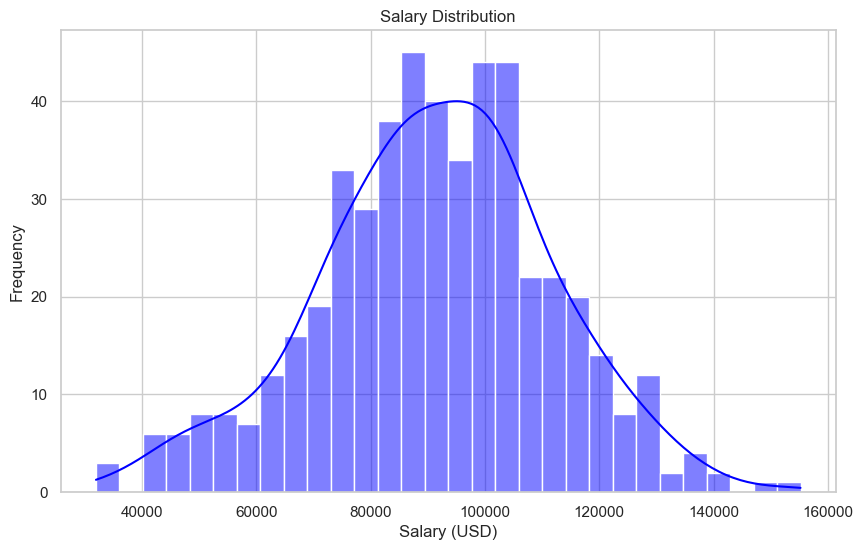

In [27]:

plt.figure(figsize=(10, 6))
sns.histplot(df[salary_col], bins=30, kde=True, color="blue")
plt.title("Salary Distribution")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.show()

### Plot the distribution of AI Adoption Level

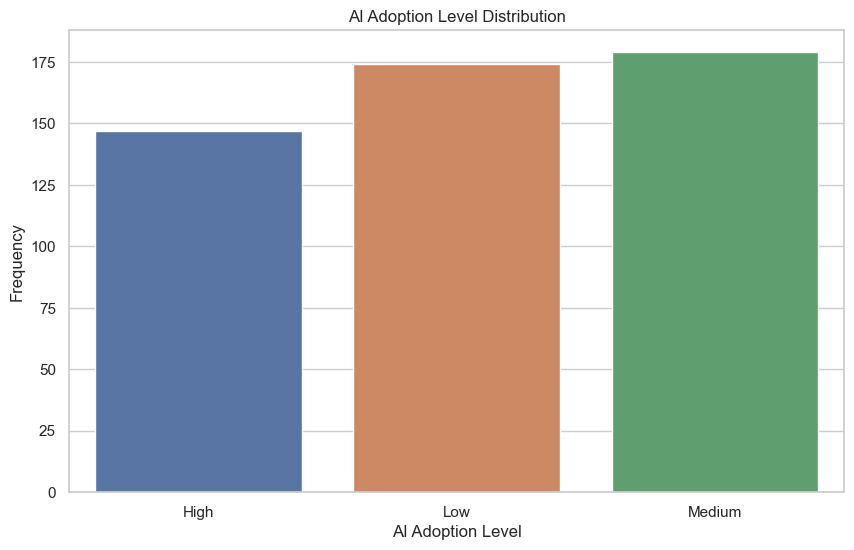

In [28]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='AI_Adoption_Level')
plt.title("AI Adoption Level Distribution")
plt.xlabel("AI Adoption Level")
plt.ylabel("Frequency")
plt.show()

### Plot boxplot of salary distribution by AI Adoption Level

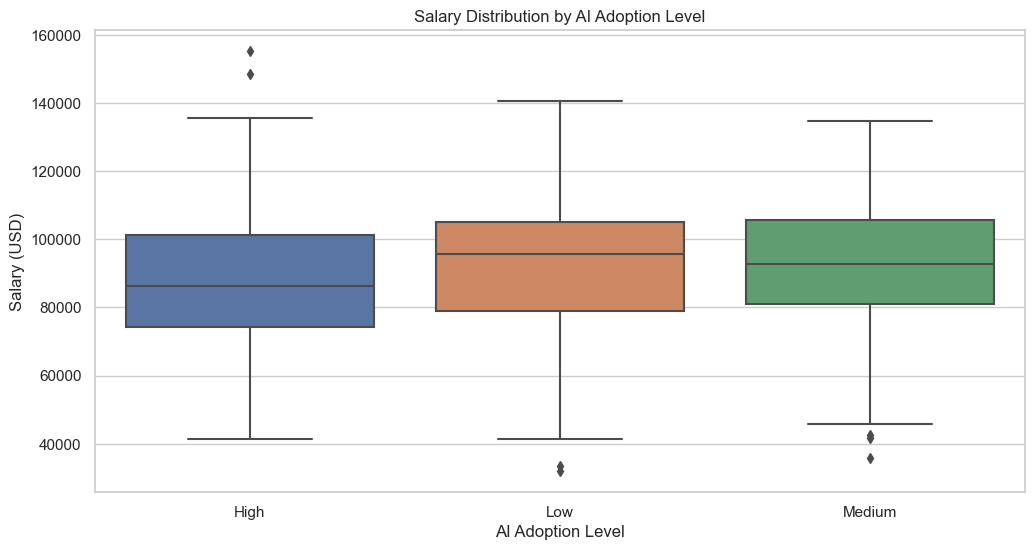

In [29]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='AI_Adoption_Level', y=salary_col)
plt.title("Salary Distribution by AI Adoption Level")
plt.xlabel("AI Adoption Level")
plt.ylabel("Salary (USD)")
plt.show()

### Plot boxplot of salary distribution by Remote Friendly

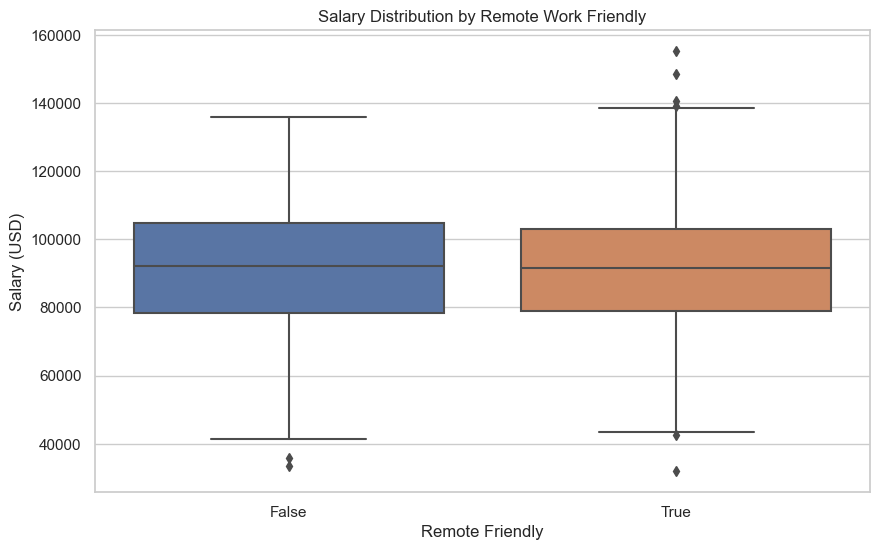

In [30]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Remote_Friendly', y=salary_col)
plt.title("Salary Distribution by Remote Work Friendly")
plt.xlabel("Remote Friendly")
plt.ylabel("Salary (USD)")
plt.show()

### Analyze average salary by top 10 industries

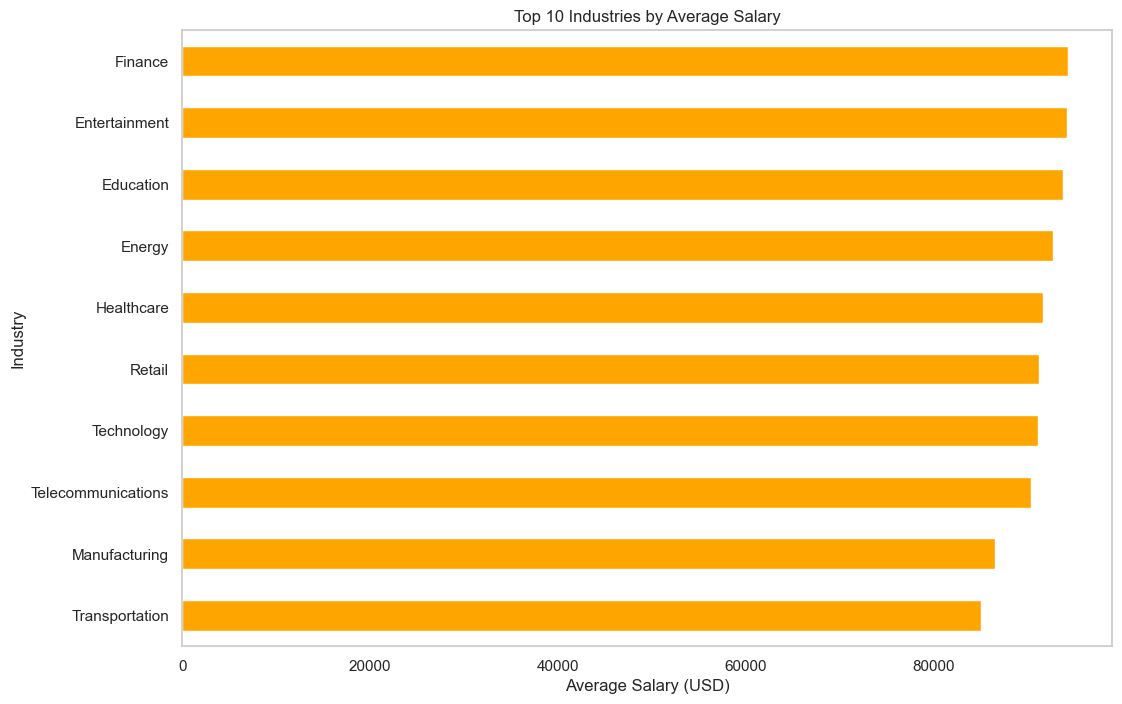

In [31]:

top_industries = df['Industry'].value_counts().nlargest(10).index
industry_salary = df[df['Industry'].isin(top_industries)].groupby('Industry')[salary_col].mean()

plt.figure(figsize=(12, 8))
industry_salary.sort_values().plot(kind='barh', color="orange")
plt.title("Top 10 Industries by Average Salary")
plt.xlabel("Average Salary (USD)")
plt.ylabel("Industry")
plt.grid()
plt.show()

### Analyze average salary by automation risk

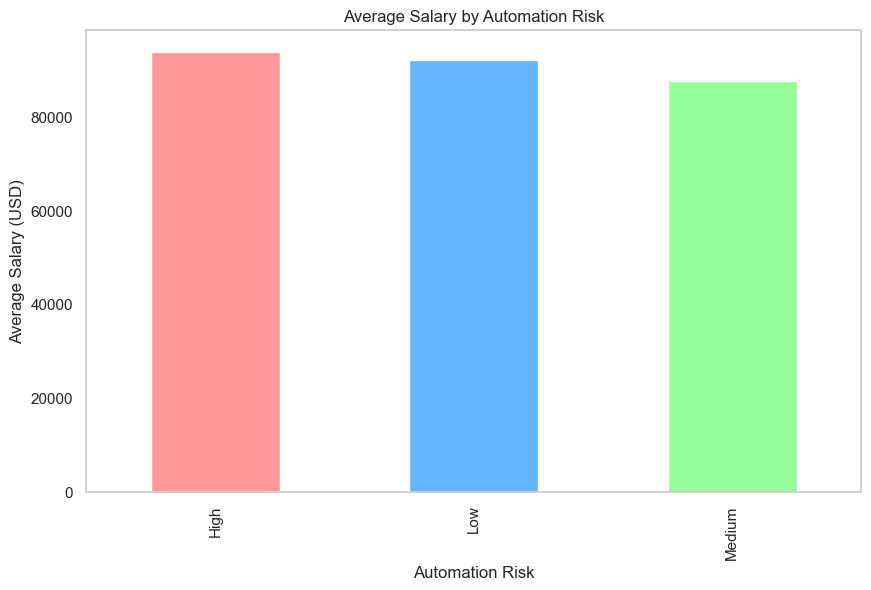

In [32]:

automation_risk_salary = df.groupby('Automation_Risk', observed=False)[salary_col].mean()

plt.figure(figsize=(10, 6))
automation_risk_salary.plot(kind='bar', color=['#ff9999', '#66b3ff', '#99ff99'])
plt.title("Average Salary by Automation Risk")
plt.xlabel("Automation Risk")
plt.ylabel("Average Salary (USD)")
plt.grid()
plt.show()

### Heatmap for AI Adoption Level by Company Size

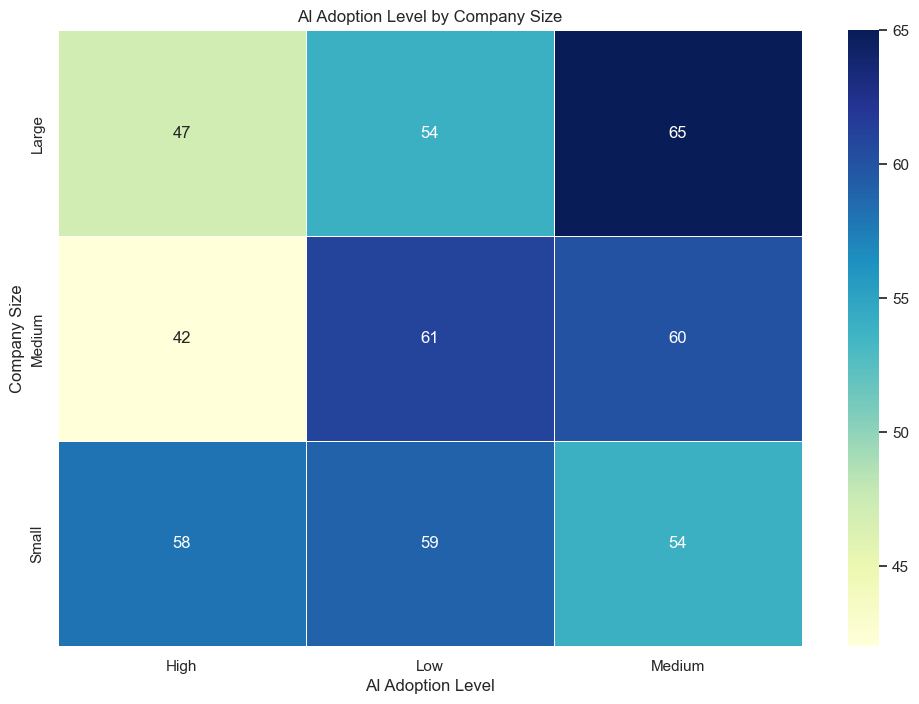

In [33]:

company_ai_adoption = df.groupby(['Company_Size', 'AI_Adoption_Level'], observed=False).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(company_ai_adoption, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title("AI Adoption Level by Company Size")
plt.xlabel("AI Adoption Level")
plt.ylabel("Company Size")
plt.show()

# Classification model

### Create Salary_Range Column

In [34]:
bins = [df['Salary_USD'].min(), 50000, 100000, df['Salary_USD'].max()]
labels = ['Low', 'Medium', 'High']
df['Salary_Range'] = pd.cut(df['Salary_USD'], bins=bins, labels=labels, include_lowest=True)

### Verify Salary_Range distribution

In [35]:
print("Salary Range Distribution:")
print(df['Salary_Range'].value_counts())

Salary Range Distribution:
Medium    310
High      172
Low        18
Name: Salary_Range, dtype: int64


### Filter data for top 3 industries by frequency

In [36]:
top_3_industries = df['Industry'].value_counts().nlargest(3).index
df_top_industries = df[df['Industry'].isin(top_3_industries)].copy()

### Map industries to integer labels

In [37]:
df_top_industries['Industry_Label'] = df_top_industries['Industry'].astype('category').cat.codes

### Verify the filtered data

In [38]:
print("Top 3 industries:", top_3_industries)
print("Industry to Label Mapping:")
print(df_top_industries[['Industry', 'Industry_Label']].drop_duplicates())

Top 3 industries: Index(['Manufacturing', 'Education', 'Technology'], dtype='object')
Industry to Label Mapping:
         Industry  Industry_Label
1      Technology               2
5       Education               0
16  Manufacturing               1


### Prepare data for classification

In [39]:
X = pd.get_dummies(df_top_industries['Salary_Range'], drop_first=True)  # Convert Salary Range to dummy variables
y = df_top_industries['Industry_Label']  # Target variable

### Split data into training and testing sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train and Evaluate Logistic Regression

In [43]:
logreg = LogisticRegression(max_iter=500, random_state=42)
params_logreg = {'C': [0.01, 0.1, 1.0, 10.0, 100.0]}
logreg_cv = GridSearchCV(logreg, param_grid=params_logreg, cv=5, scoring='accuracy')
logreg_cv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500, random_state=42),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
             scoring='accuracy')

In [44]:
logreg_best = logreg_cv.best_estimator_
y_pred_logreg = logreg_best.predict(X_test)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.2f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.36      0.69      0.47        13
           2       0.00      0.00      0.00        11

    accuracy                           0.37        35
   macro avg       0.25      0.35      0.28        35
weighted avg       0.26      0.37      0.30        35

Accuracy: 0.37


### Visualizing Confusion Matrix

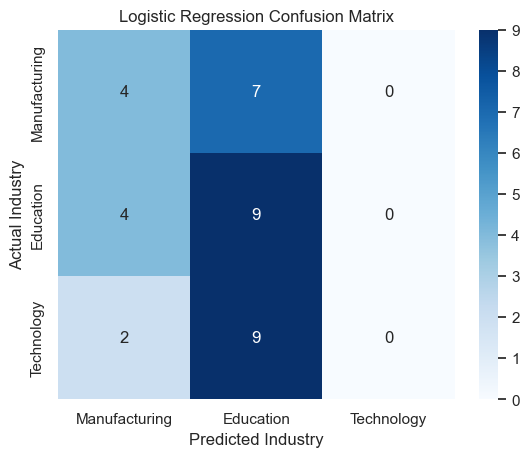

In [45]:
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=top_3_industries, yticklabels=top_3_industries)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Industry")
plt.ylabel("Actual Industry")
plt.show()

### Train and Evaluate Random Forest

In [46]:
rf_clf = RandomForestClassifier(random_state=42)
params_rf_clf = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
rf_clf_cv = GridSearchCV(rf_clf, param_grid=params_rf_clf, cv=5, scoring='accuracy')
rf_clf_cv.fit(X_train, y_train)

rf_clf_best = rf_clf_cv.best_estimator_
y_pred_rf_clf = rf_clf_best.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_clf, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_clf):.2f}")



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.36      0.69      0.47        13
           2       0.00      0.00      0.00        11

    accuracy                           0.37        35
   macro avg       0.25      0.35      0.28        35
weighted avg       0.26      0.37      0.30        35

Accuracy: 0.37


### Visualizing Random Forest Confusion Matrix

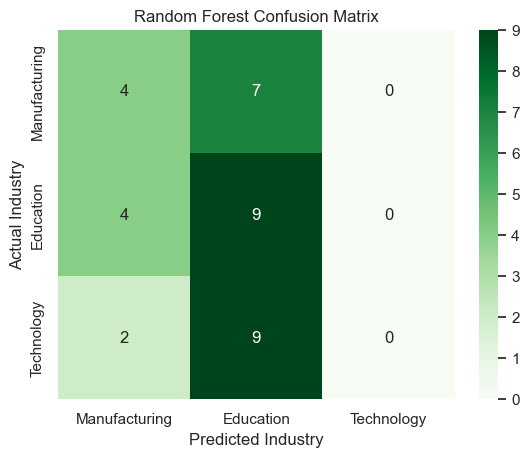

In [48]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf_clf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=top_3_industries, yticklabels=top_3_industries)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Industry")
plt.ylabel("Actual Industry")
plt.show()